# DSCI 511: Data Acquisition and Pre-Processing <br> Term Project Phase 1: Scoping a data set

#Project 1

##Teamwork

- What areas/skills/domains does the team member presently identify with? Into which areas/skills/domains would the team member like to grow?

  **Kexin Shang** has a background in data science and statistics. She is adept in data analysis including statistical inference and modeling. While she has some prior experience in both a bioinformatics project and a quantitative psychology project, she has only worked with organized data and does not believe that she has solid foundation in collecting data from scratch. Therefore, she would like to practice how to structure raw data into an informative format during an up-stream data science stage.

  **Andy Cherney** has a background in data science and statistics. He also has skills in data analysis including statistical inference and modeling. Additionally, he brings an extensive technical knowledge of programming in Python and R; he worked primarily with organized datasets in these two languages. Although he has some experience with APIs and Webscraping, his experience in this area comes from automating the process of creating flashcards for his self-study of the Japanese language. Hence, he would like to expand his knowledge to the real world by collecting and building a real-world dataset that can be used to solve real-world problems and be transferrable across different industry domains.

  **Robert Logovinsky** has a background in data analysis and information technology support. He has worked with a variety of data sets in a variety of different applications, from finance to logitistics and even NBA shot data and load metrics. Nevertheless, his strongest attribute is his ability to manage a project and provide guidance. In light of this, he will be best suited as a PM for the group, while simultaneously learning python and improving on his coding skills.

  **Abbeer Wani** has a backgound in Computer Science and Engineering. She has primarily worked on projects involving data from the medical industry and those with an analytical foundation. She has the capacity to quickly acclimate to a project's specific technical requirements. She is quite proficient in arithmetic and combinatractos.  She would like gain more insights over data retrieval and data visulaization.

- Individual contributions

  **Robert Logovinsky** is our project manager. He will be responsible for tracking our overall progress, setting up milestone for individual tasks and making sure eveyone is on the same page.

  **Andy Cherney** serves as the data scraper in our group. He will combine multiple APIs to obtain both current and historical weather data in an appropriate JSON format for later use.

  **Kexin Shang** is our data cleaner. She will clean and manipulate the raw data that Andy has compiled into more manageable dataframes that are primed for analysis.

  **Abbeer Wani** is our data visualization specialist. She will convert the cleaned data from Kexin into an interactive map.

# Import Modules

In [ ]:
import requests as r
import pandas as pd
import datetime
from bs4 import BeautifulSoup
import re
from time import sleep
import os
import json

from scipy.stats import mode

# Data Acquisition

Our plan is to first gather weather data for the top 20 cities with the highest population. To start, we scraped the Wikipedia website of US cities by population

https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population

In [ ]:
url = "https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population"
response = r.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
population_table=soup.find('table', class_='wikitable sortable')
population_table.prettify()

'<table class="wikitable sortable" style="text-align:center">\n <tbody>\n  <tr>\n   <th scope="col">\n    2022\n    <br/>\n    rank\n   </th>\n   <th scope="col">\n    City\n   </th>\n   <th scope="col">\n    State\n    <sup class="reference" id="cite_ref-5">\n     <a href="#cite_note-5">\n      [c]\n     </a>\n    </sup>\n   </th>\n   <th scope="col">\n    2022\n    <br/>\n    estimate\n   </th>\n   <th scope="col">\n    2020\n    <br/>\n    census\n   </th>\n   <th scope="col">\n    Change\n   </th>\n   <th colspan="2" scope="col">\n    2020 land area\n   </th>\n   <th colspan="2" scope="col">\n    2020 population density\n   </th>\n   <th scope="col">\n    Location\n   </th>\n  </tr>\n  <tr>\n   <th scope="row">\n    1\n   </th>\n   <td style="text-align:left;background-color:#cfecec">\n    <i>\n     <a href="/wiki/New_York_City" title="New York City">\n      New York\n     </a>\n    </i>\n    <sup class="reference" id="cite_ref-6">\n     <a href="#cite_note-6">\n      [d]\n     </a

In [ ]:
keys = ['city', 'state']

In [ ]:
def get_top_cities(n):
    data_ls = []
    for row in population_table.find_all('tr')[1:n+1]:

        city_state = {}
        for i, value in enumerate(row.find_all('td')[:len(keys)]):
            value = re.sub(r"\[\w+\]|[,%/\xa0\+\ufeff;]|km2|mi|sq",'',value.text.strip())
            city_state[keys[i % len(keys)]] = value
        data_ls.append(city_state)
    return data_ls


In [ ]:
cities = pd.DataFrame(get_top_cities(20))
cities

,city,state
0,New York,New York
1,Los Angeles,California
2,Chicago,Illinois
3,Houston,Texas
4,Phoenix,Arizona
5,Philadelphia,Pennsylvania
6,San Antonio,Texas
7,San Diego,California
8,Dallas,Texas
9,Austin,Texas


### The Weather and AQI Data

We now need to scrape the hourly weather and aqi data from the OpenMeteo API. To start, this is a generic function for the API call. We will first use it to gather the coordinates for each city.

In [ ]:

def fetch_data(endpoint, rate_limit=0.25,**params):

    # Group API endpoints depending on the pattern of the url
    e1 = {'air-quality', 'marine', 'ensemble', 'climate', 'archive', 'flood'}
    e2 = {'forecast','elevation'}
    geocode = {'geocoding'}

    if endpoint in e1:
        api_url = f"https://{endpoint}-api.open-meteo.com/v1/{endpoint}"
    elif endpoint in e2:
        api_url = f"https://api.open-meteo.com/v1/{endpoint}"
    elif endpoint in geocode:
            api_url = f"https://{endpoint}-api.open-meteo.com/v1/search"
    else:
        raise ValueError(f"Endpoint not available. Must be in {e1 | e2 | geocode}")


    response = r.get(api_url, params=params)
    results = response.json()
    sleep(rate_limit) #  Time delay between requests to ensure fair usage


    if endpoint == 'geocoding':
            best_result = results['results'][0]
            data = {'id': best_result['id'],
                    'latitude': best_result['latitude'],
                    'longitude': best_result['longitude']}
            print(data)
            return data

    return results


In [ ]:
coords = [fetch_data('geocoding',name=city, cnt=10) for city in cities['city']]


{'id': 5128581, 'latitude': 40.71427, 'longitude': -74.00597}
{'id': 5368361, 'latitude': 34.05223, 'longitude': -118.24368}
{'id': 4887398, 'latitude': 41.85003, 'longitude': -87.65005}
{'id': 4699066, 'latitude': 29.76328, 'longitude': -95.36327}
{'id': 5308655, 'latitude': 33.44838, 'longitude': -112.07404}
{'id': 4560349, 'latitude': 39.95233, 'longitude': -75.16379}
{'id': 4726206, 'latitude': 29.42412, 'longitude': -98.49363}
{'id': 5391811, 'latitude': 32.71571, 'longitude': -117.16472}
{'id': 4684888, 'latitude': 32.78306, 'longitude': -96.80667}
{'id': 4671654, 'latitude': 30.26715, 'longitude': -97.74306}
{'id': 4160021, 'latitude': 30.33218, 'longitude': -81.65565}
{'id': 5392171, 'latitude': 37.33939, 'longitude': -121.89496}
{'id': 4691930, 'latitude': 32.72541, 'longitude': -97.32085}
{'id': 4509177, 'latitude': 39.96118, 'longitude': -82.99879}
{'id': 4460243, 'latitude': 35.22709, 'longitude': -80.84313}
{'id': 4259418, 'latitude': 39.76838, 'longitude': -86.15804}
{'id

In [ ]:
cities_with_coords = pd.concat([cities, pd.DataFrame(coords)], axis=1)
cities_with_coords.set_index('id', inplace=True)
cities_with_coords

,city,state,latitude,longitude
id,,,,
5128581,New York,New York,40.71427,-74.00597
5368361,Los Angeles,California,34.05223,-118.24368
4887398,Chicago,Illinois,41.85003,-87.65005
4699066,Houston,Texas,29.76328,-95.36327
5308655,Phoenix,Arizona,33.44838,-112.07404
4560349,Philadelphia,Pennsylvania,39.95233,-75.16379
4726206,San Antonio,Texas,29.42412,-98.49363
5391811,San Diego,California,32.71571,-117.16472
4684888,Dallas,Texas,32.78306,-96.80667


This next step will be to define a function that collects all the data we need from OpenMeteo. This process will also be run in parallel threads by row for efficiency. After that, we can simply loop over each thread object to get the result.

In [ ]:
# Function to fetch all the data we need

def fetch_all_data(row):
    aqi = fetch_data("air-quality",latitude=row['latitude'], longitude=row['longitude'], hourly="uv_index_clear_sky,us_aqi_pm2_5,us_aqi_co,us_aqi_o3",
           start_date="2022-11-01", end_date="2023-11-01")
    historical = fetch_data("archive",latitude=row['latitude'], longitude=row['longitude'],
                            hourly="temperature_2m,relativehumidity_2m,precipitation_probability,precipitation,rain,windspeed_10m",
           start_date="2022-11-01", end_date="2023-11-01")

    return aqi, historical

In [ ]:
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(max_workers=cities_with_coords.shape[0]) as executor:
    threads = [executor.submit(fetch_all_data,row=row) for id,row in cities_with_coords.iterrows()]


print(threads[0].result())

({'latitude': 40.800003, 'longitude': -74.0, 'generationtime_ms': 1.522064208984375, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 51.0, 'hourly_units': {'time': 'iso8601', 'uv_index_clear_sky': '', 'us_aqi_pm2_5': 'USAQI', 'us_aqi_co': 'USAQI', 'us_aqi_o3': 'USAQI'}, 'hourly': {'time': ['2022-11-01T00:00', '2022-11-01T01:00', '2022-11-01T02:00', '2022-11-01T03:00', '2022-11-01T04:00', '2022-11-01T05:00', '2022-11-01T06:00', '2022-11-01T07:00', '2022-11-01T08:00', '2022-11-01T09:00', '2022-11-01T10:00', '2022-11-01T11:00', '2022-11-01T12:00', '2022-11-01T13:00', '2022-11-01T14:00', '2022-11-01T15:00', '2022-11-01T16:00', '2022-11-01T17:00', '2022-11-01T18:00', '2022-11-01T19:00', '2022-11-01T20:00', '2022-11-01T21:00', '2022-11-01T22:00', '2022-11-01T23:00', '2022-11-02T00:00', '2022-11-02T01:00', '2022-11-02T02:00', '2022-11-02T03:00', '2022-11-02T04:00', '2022-11-02T05:00', '2022-11-02T06:00', '2022-11-02T07:00', '2022-11-02T08:00', '2022-11

#Data Wrangling

by Kexin (Summer) Shang

In the above data acquisition process, we obtained ordinnation of top N cities and with the (lat, long) geocoder we can access the aqi and temperature data by hour via weather API.

The following code blocks aims to organize each city's info into a nested json file. We plan to store one-year span historical data of each city by date and by month, sepreately into two dictionaries.

The *daily_data* dictionary contains cityID as key and an information dataframe as the value. As in the information dataframe, there are the max, min and avg value of temperature variables (because they are continous) and the cumulative frequency of each aqi variables (becuase they are categorical) per day during the 1-year span.

Similarly, the *month_data* dictionary store the same information but only by month.

In [ ]:
daily_data = {} # Will be a dictionary of city ids with the corresponding dataframe as the value
monthly_data = {}

for (id, row), thread in zip(cities_with_coords.iterrows(),threads):
    aqi, historical = thread.result()
    aqi_hourly, historical_hourly = aqi['hourly'], historical['hourly']

    hourly_info = pd.merge(pd.DataFrame(historical_hourly), pd.DataFrame(aqi_hourly), on=["time"]) # the original info is by hour
    hourly_info['date'] = pd.to_datetime(hourly_info['time']).dt.to_period("D")
    hourly_info['month'] = pd.to_datetime(hourly_info['time']).dt.to_period("M")

    labels = ['Good','Moderate','Unhealthy for sensitive groups', 'Unhealthy', 'Very unhealthy', 'Hazardous'] # convert AQI variables into 5 levels
    cutOffs = [-1,50,100,150,200,300,9999]
    hourly_info['us_aqi_pm2_5_cat'] = pd.cut(hourly_info['us_aqi_pm2_5'], bins = cutOffs, labels = labels) # create new aqi columns that are categorical by cut-off points
    hourly_info['us_aqi_co_cat'] = pd.cut(hourly_info['us_aqi_co'], bins = cutOffs, labels = labels)
    hourly_info['us_aqi_o3_cat'] = pd.cut(hourly_info['us_aqi_o3'], bins = cutOffs, labels = labels)

    colName = list(hourly_info.columns)
    num_groupby_dictionary  = dict(zip( colName[1:7],[['mean', 'min','max']]*len(colName[1:7]))) # create a dictionary to tell groupby.agg() function to grab mean, min and max for all temperature variables
    cat_colName = colName[-3:] # these are the three aqi_cat variables, we want to count their frequency later

    for dayOrMonth in ['date','month']:
      info = hourly_info.groupby(dayOrMonth).agg(num_groupby_dictionary) # these are min, max, mean of continous temperature variables
      for aqi_cat in cat_colName:
        aqi_freq = hourly_info.groupby([dayOrMonth]+[aqi_cat])[aqi_cat].count().unstack() # these are initially multilevel frequency aqi variables and then got unstacked
        unstack_colName = [aqi_freq.columns.name[:-3] + col for col in list(aqi_freq.columns)]
        aqi_freq = aqi_freq.rename(columns=dict(zip(list(aqi_freq.columns),unstack_colName)))
        info = pd.merge(info,aqi_freq,on=dayOrMonth)  # merge the temperature part and the aqi part

      if (dayOrMonth == 'date'):
        daily_data.update({id: info})
      else:
        monthly_data.update({id: info})

<ipython-input-11-2938c37abb71>:28: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  info = pd.merge(info,aqi_freq,on=dayOrMonth)  # merge the temperature part and the aqi part
<ipython-input-11-2938c37abb71>:28: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  info = pd.merge(info,aqi_freq,on=dayOrMonth)  # merge the temperature part and the aqi part
<ipython-input-11-2938c37abb71>:28: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  info = pd.merge(info,aqi_freq,on=dayOrMonth)  # merge the temperature part and the aqi part
<ipython-input-11-2938c37abb71>:28: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  info


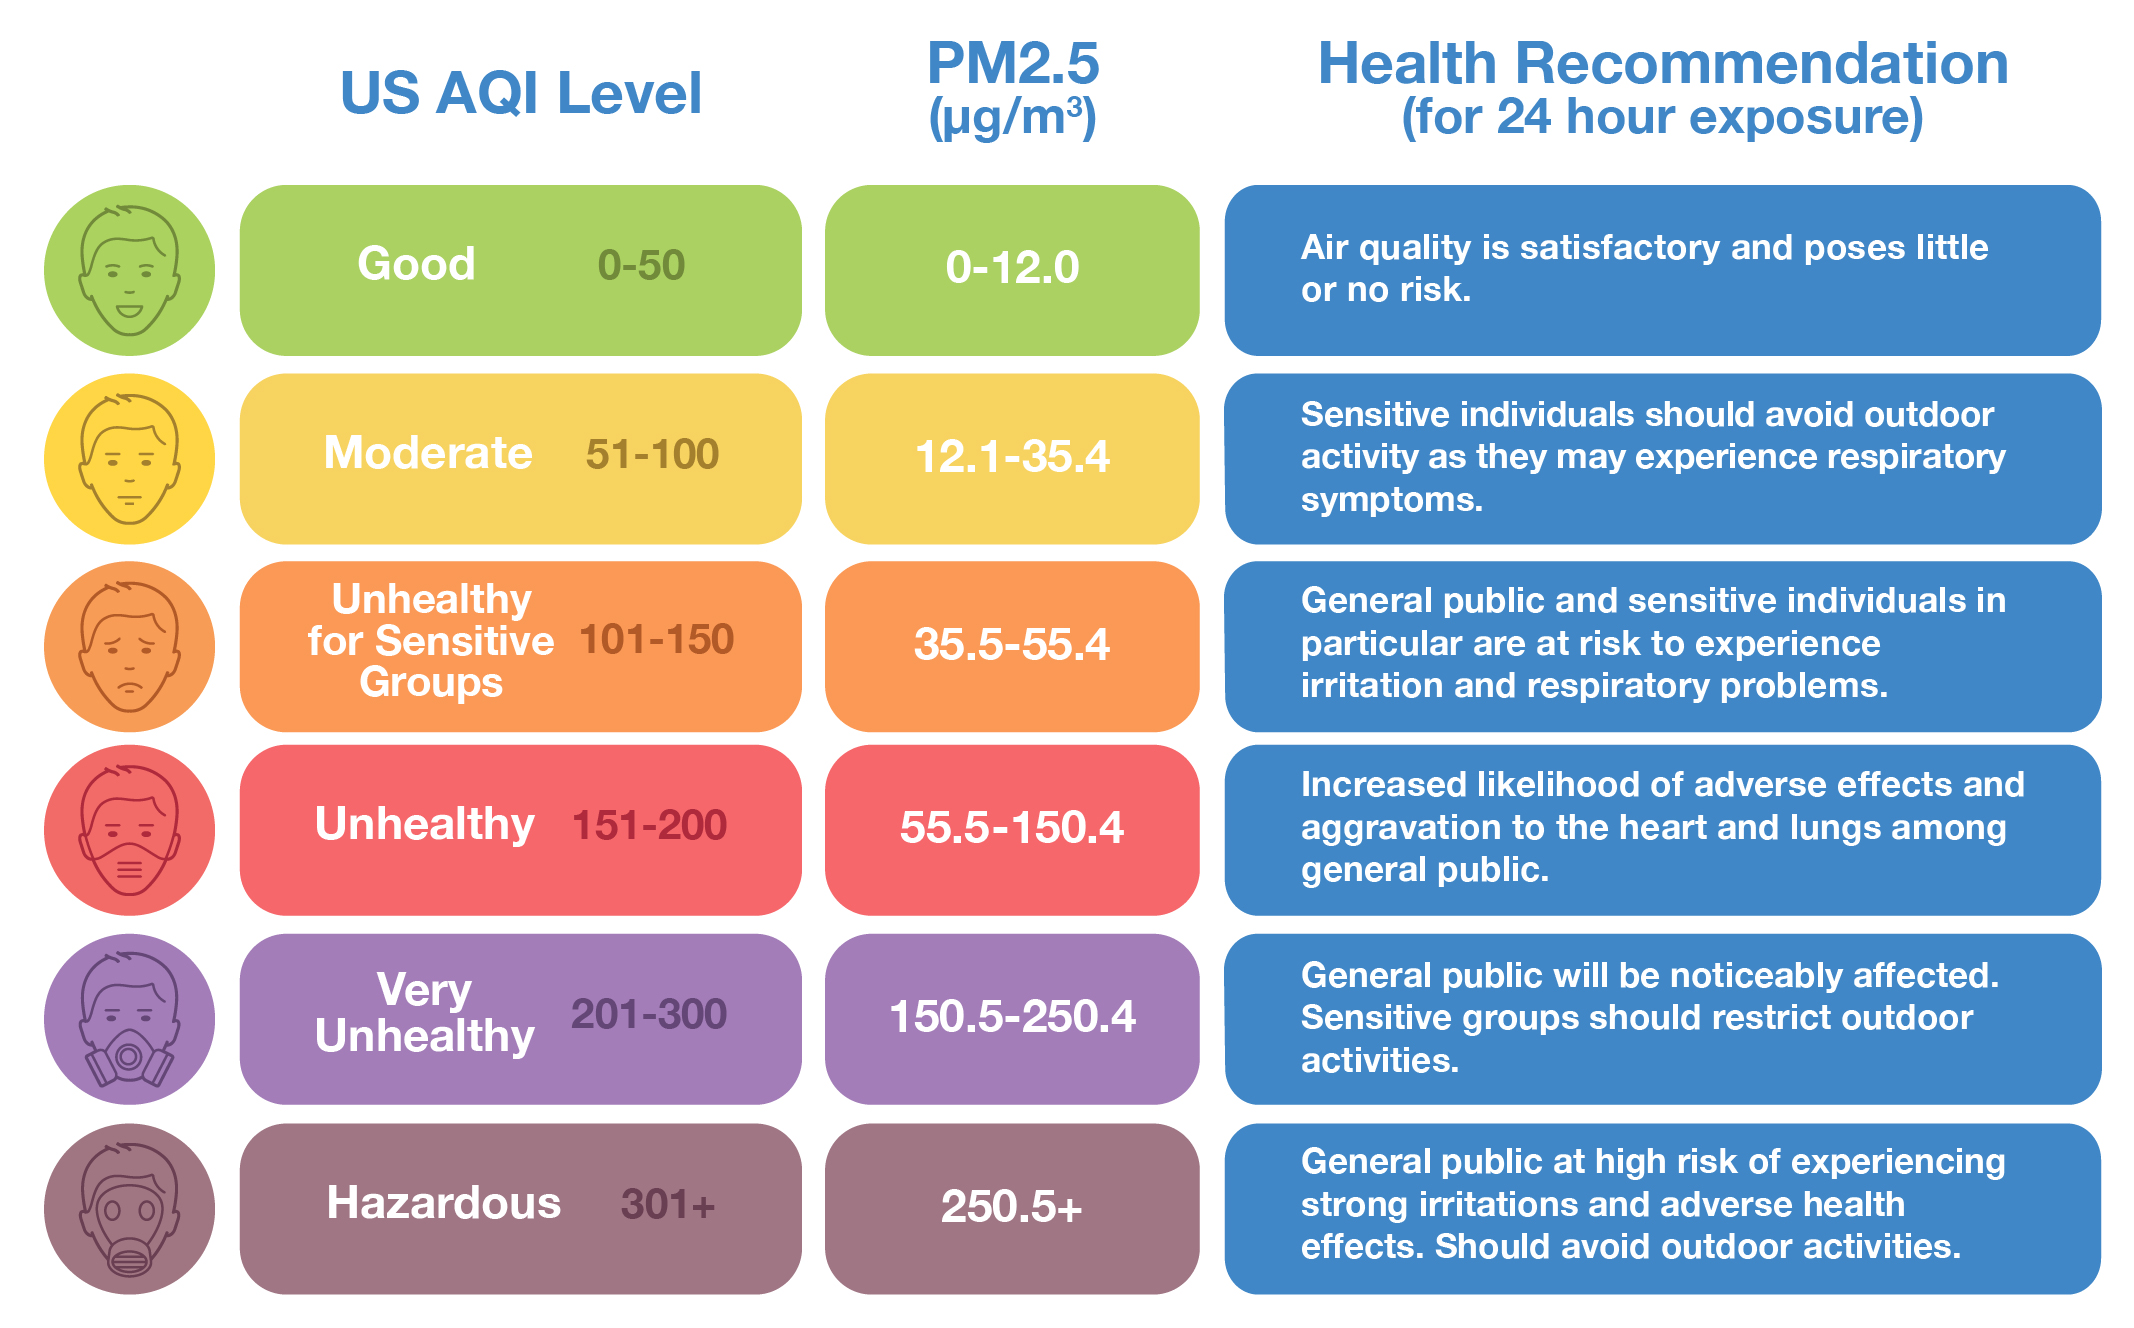

In [ ]:
# Missing value check: all good!
hourly_info.isnull().sum()

time                   0
temperature_2m         0
relativehumidity_2m    0
precipitation          0
rain                   0
windspeed_10m          0
uv_index_clear_sky     0
us_aqi_pm2_5           0
us_aqi_co              0
us_aqi_o3              0
date                   0
month                  0
us_aqi_pm2_5_cat       0
us_aqi_co_cat          0
us_aqi_o3_cat          0
dtype: int64

A preview of *daily_data* dictionary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
len(daily_data)

20

In [ ]:
daily_data.keys()

dict_keys([5128581, 5368361, 4887398, 4699066, 5308655, 4560349, 4726206, 5391811, 4684888, 4671654, 4160021, 5392171, 4691930, 4509177, 4460243, 4259418, 5391959, 5809844, 5419384, 4544349])



Example, this is for New York city:

In [ ]:
daily_data[5128581]

,"(temperature_2m, mean)","(temperature_2m, min)","(temperature_2m, max)","(relativehumidity_2m, mean)","(relativehumidity_2m, min)","(relativehumidity_2m, max)","(precipitation, mean)","(precipitation, min)","(precipitation, max)","(rain, mean)",...,us_aqi_co_Unhealthy for sensitive groups,us_aqi_co_Unhealthy,us_aqi_co_Very unhealthy,us_aqi_co_Hazardous,us_aqi_o3_Good,us_aqi_o3_Moderate,us_aqi_o3_Unhealthy for sensitive groups,us_aqi_o3_Unhealthy,us_aqi_o3_Very unhealthy,us_aqi_o3_Hazardous
date,,,,,,,,,,,,,,,,,,,,,
2022-11-01,15.362500,12.9,19.6,90.833333,71,99,0.562500,0.0,4.1,0.562500,...,0,0,0,0,24,0,0,0,0,0
2022-11-02,14.979167,10.5,19.9,77.875000,51,91,0.000000,0.0,0.0,0.000000,...,0,0,0,0,24,0,0,0,0,0
2022-11-03,12.354167,8.3,17.7,80.083333,54,95,0.000000,0.0,0.0,0.000000,...,0,0,0,0,24,0,0,0,0,0
2022-11-04,12.966667,7.9,19.5,90.583333,75,100,0.000000,0.0,0.0,0.000000,...,0,0,0,0,24,0,0,0,0,0
2022-11-05,17.716667,14.8,22.8,84.750000,69,94,0.000000,0.0,0.0,0.000000,...,0,0,0,0,24,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-28,20.191667,16.1,26.8,73.125000,50,87,0.000000,0.0,0.0,0.000000,...,0,0,0,0,24,0,0,0,0,0
2023-10-29,13.800000,11.3,20.6,75.583333,61,95,0.262500,0.0,3.0,0.262500,...,0,0,0,0,24,0,0,0,0,0
2023-10-30,13.708333,10.4,18.9,90.458333,72,100,0.108333,0.0,0.7,0.108333,...,0,0,0,0,24,0,0,0,0,0


#### Save the daily and monthly json files

In [ ]:
daily_json = {}
for key in daily_data.keys():
  daily_json[key] = daily_data[key].to_json()

In [ ]:
with open('daily_json.json', 'w', encoding ='utf8') as json_file:
    json.dump(daily_json, json_file, ensure_ascii = False)

In [ ]:
monthly_json = {}
for key in monthly_data.keys():
  monthly_json[key] = monthly_data[key].to_json()

In [ ]:
with open('monthly_json.json', 'w', encoding ='utf8') as json_file:
    json.dump(monthly_json, json_file, ensure_ascii = False)

VISUALIZATIONS

By Abbeer Wani

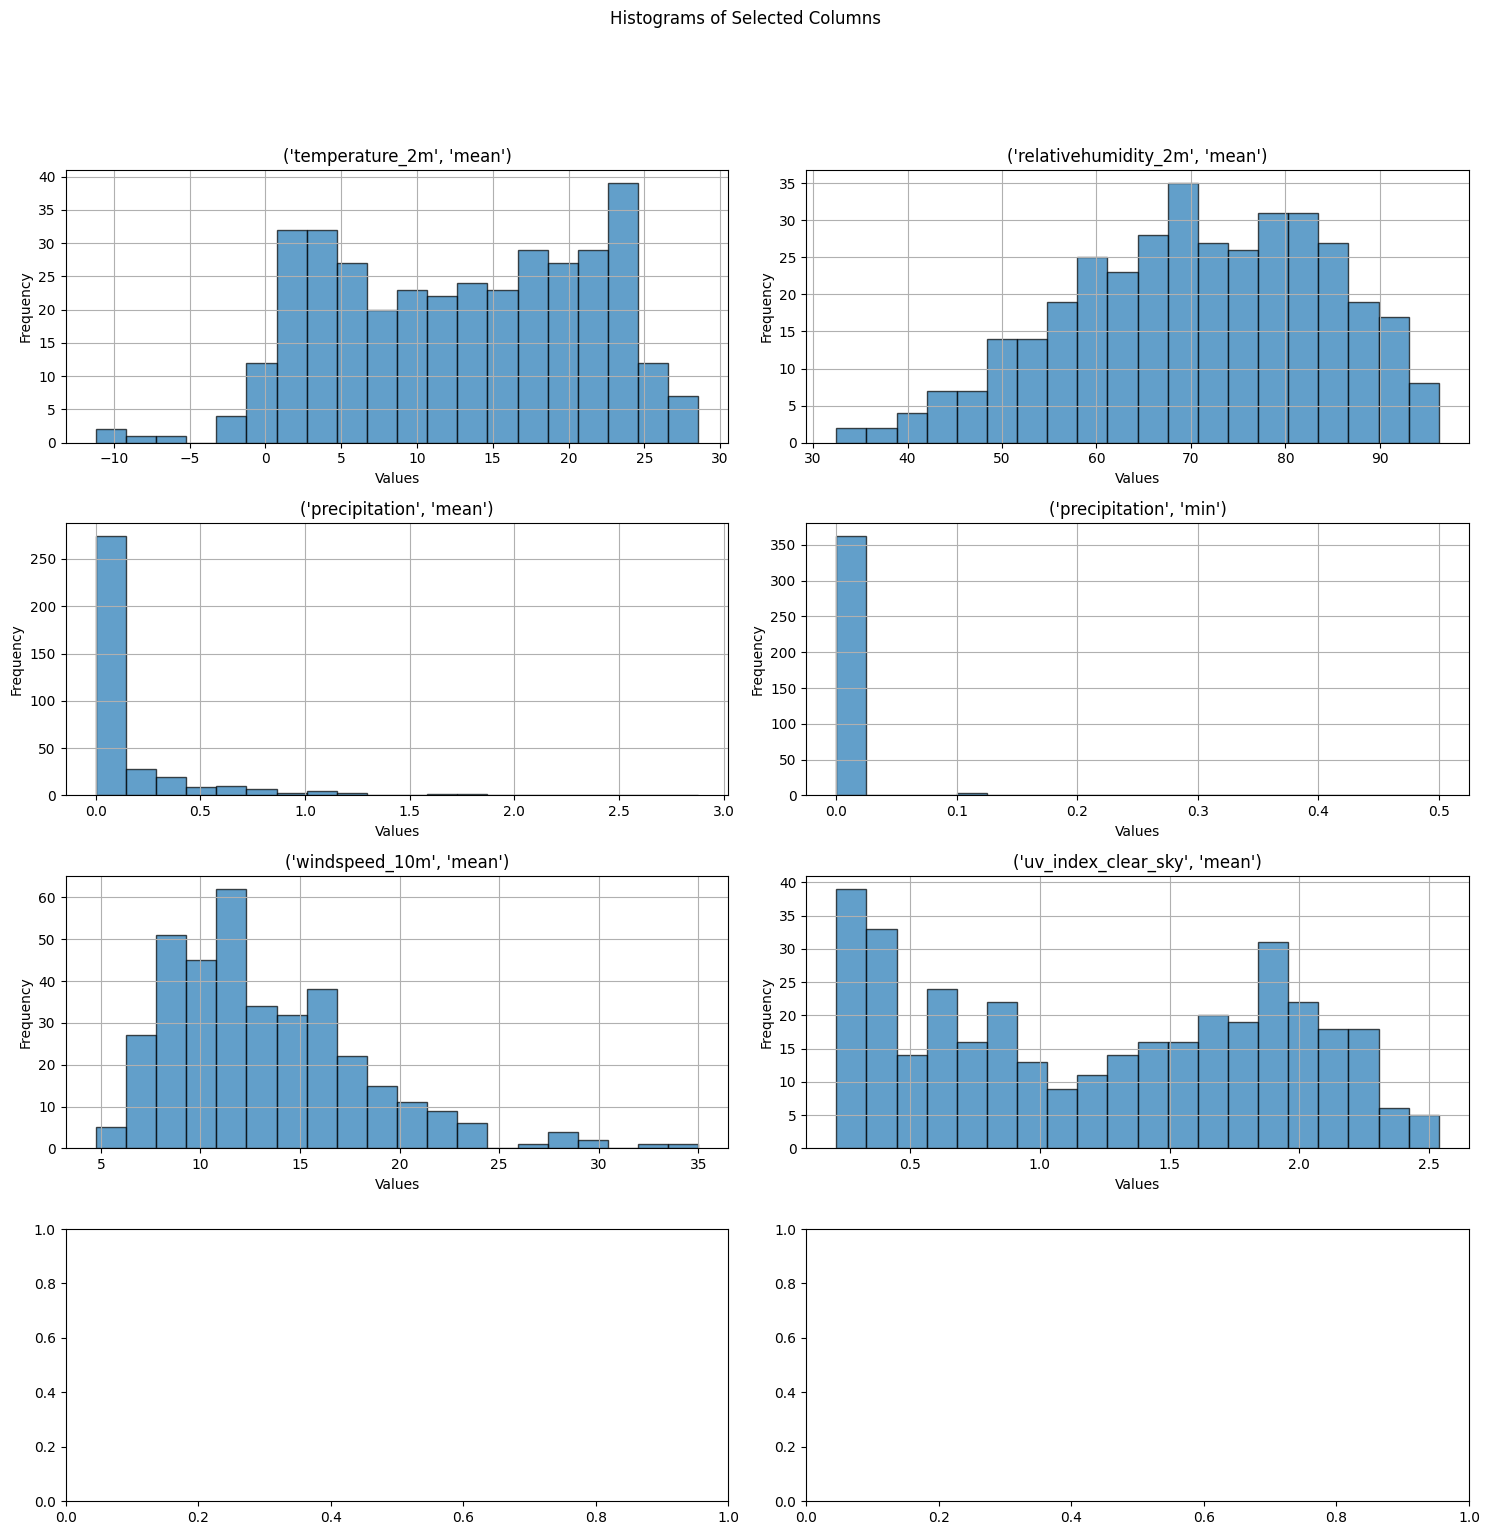

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


df = daily_data[5128581]

selected_columns = [
    ('temperature_2m', 'mean'),
    ('relativehumidity_2m', 'mean'),
    ('precipitation', 'mean'),
    ('precipitation', 'min'),
    ('windspeed_10m', 'mean'),
    ('uv_index_clear_sky', 'mean')

]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
fig.suptitle('Histograms of Selected Columns', y=1.02)

for ax, column in zip(axes.flatten(), selected_columns):
    df[column].hist(bins=20, edgecolor='black', alpha=0.7, ax=ax)
    ax.set_title(column)
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


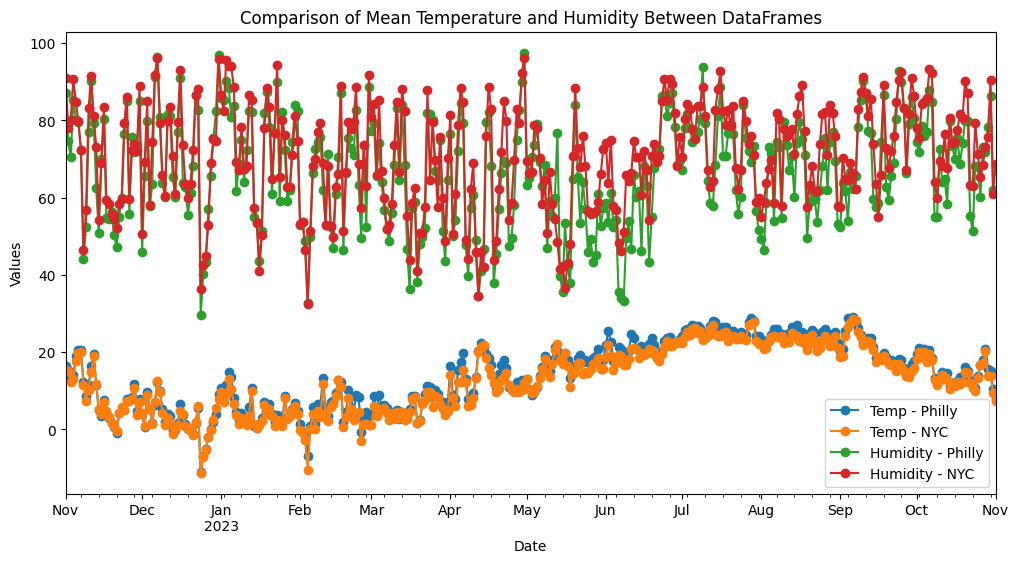

In [ ]:
import matplotlib.pyplot as plt

df1 = daily_data[4560349]
df2 = daily_data[5128581]

mean_temp_df1 = df1[('temperature_2m', 'mean')]
mean_temp_df2 = df2[('temperature_2m', 'mean')]

mean_humidity_df1 = df1[('relativehumidity_2m', 'mean')]
mean_humidity_df2 = df2[('relativehumidity_2m', 'mean')]


plt.figure(figsize=(12, 6))
mean_temp_df1.plot(label='Temp - Philly', linestyle='-', marker='o')
mean_temp_df2.plot(label='Temp - NYC', linestyle='-', marker='o')


mean_humidity_df1.plot(label='Humidity - Philly', linestyle='-', marker='o')
mean_humidity_df2.plot(label='Humidity - NYC', linestyle='-', marker='o')


plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison of Mean Temperature and Humidity Between DataFrames')
plt.legend()

plt.show()


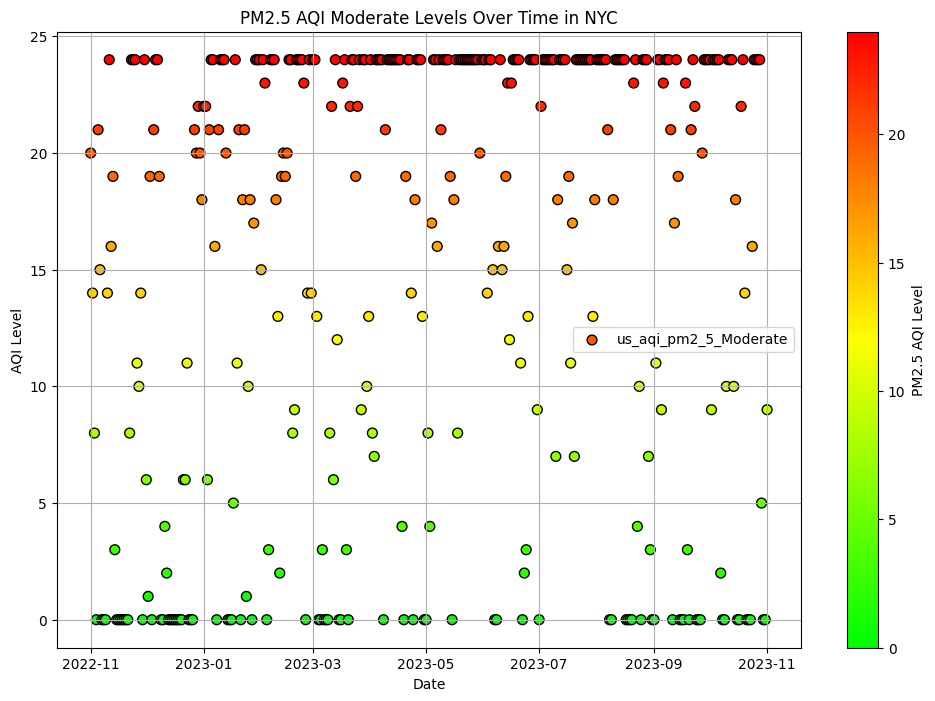

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

df = daily_data[5128581]
selected_column = 'us_aqi_pm2_5_Moderate'
x_values = df.index.to_timestamp()
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#00FF00', '#FFFF00', '#FF0000'])

plt.figure(figsize=(12, 8))
plt.scatter(x_values, df[selected_column], c=df[selected_column], cmap=cmap, marker='o', s=50, edgecolors='black', linewidth=1, label=selected_column)

plt.title(f'PM2.5 AQI Moderate Levels Over Time in NYC')
plt.xlabel('Date')
plt.ylabel('AQI Level')

cbar = plt.colorbar()
cbar.set_label('PM2.5 AQI Level')

plt.grid(True)
plt.legend()

plt.show()


<Figure size 1200x800 with 0 Axes>

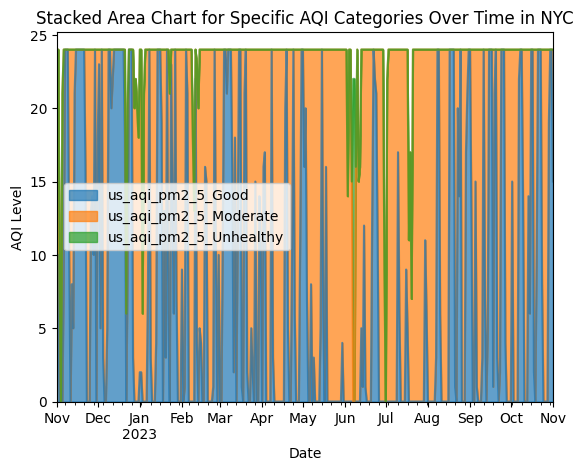

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = daily_data[5128581]

selected_categories = ['us_aqi_pm2_5_Good', 'us_aqi_pm2_5_Moderate', 'us_aqi_pm2_5_Unhealthy']

df_selected = df[selected_categories]

plt.figure(figsize=(12, 8))
df_selected.plot.area(stacked=True, alpha=0.7)

plt.title('Stacked Area Chart for Specific AQI Categories Over Time in NYC')
plt.xlabel('Date')
plt.ylabel('AQI Level')

plt.show()


<Figure size 1200x800 with 0 Axes>

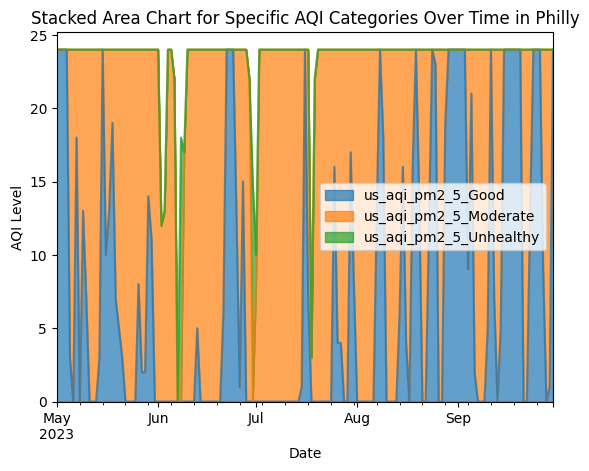

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


df = daily_data[4560349]


selected_categories = ['us_aqi_pm2_5_Good', 'us_aqi_pm2_5_Moderate', 'us_aqi_pm2_5_Unhealthy']


start_date = '2023-05-01'
end_date = '2023-09-30'
df = df[start_date:end_date]


df_selected = df[selected_categories]


plt.figure(figsize=(12, 8))
df_selected.plot.area(stacked=True, alpha=0.7)

plt.title('Stacked Area Chart for Specific AQI Categories Over Time in Philly')
plt.xlabel('Date')
plt.ylabel('AQI Level')

plt.show()


<Figure size 1200x800 with 0 Axes>

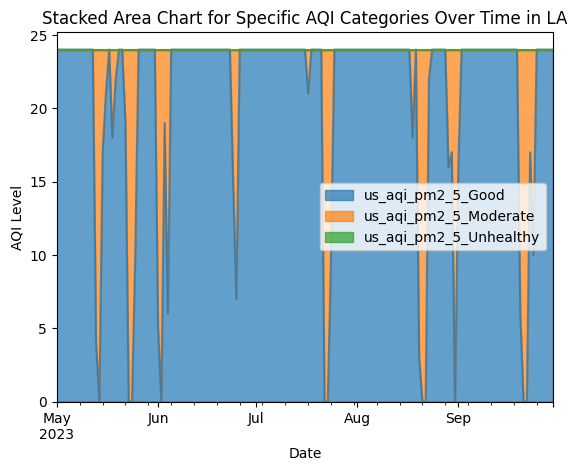

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = daily_data[5391959]


selected_categories = ['us_aqi_pm2_5_Good', 'us_aqi_pm2_5_Moderate', 'us_aqi_pm2_5_Unhealthy']


start_date = '2023-05-01'
end_date = '2023-09-30'
df = df[start_date:end_date]


df_selected = df[selected_categories]


plt.figure(figsize=(12, 8))
df_selected.plot.area(stacked=True, alpha=0.7)

plt.title('Stacked Area Chart for Specific AQI Categories Over Time in LA')
plt.xlabel('Date')
plt.ylabel('AQI Level')

plt.show()


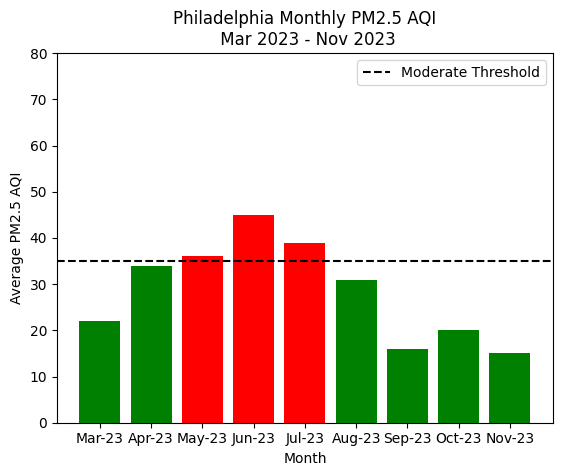

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {'Month': ['Mar-23','Apr-23','May-23','Jun-23','Jul-23','Aug-23','Sep-23','Oct-23','Nov-23'],
        'AQI': [22, 34, 36, 45, 39, 31, 16, 20, 15]}

df = pd.DataFrame(data)

plt.bar(df['Month'], df['AQI'], color=['green' if aqi <= 35 else 'red' for aqi in df['AQI']])

plt.ylabel('Average PM2.5 AQI')
plt.xlabel('Month')
plt.title('Philadelphia Monthly PM2.5 AQI\n Mar 2023 - Nov 2023')
plt.ylim(0, 80)

plt.axhline(35, color='black', linestyle='dashed', label='Moderate Threshold')
plt.legend()

plt.show()